Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

df = pd.read_csv('/datasets/autos.csv')

## 1.1 Просмотр данных

In [2]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Есть столбцы, которые можно преоброзовать в Дату/время
- В столбцах **Price**, **RegistrationYear**, **Power**, **RegistrationMonth**  есть "неадекватные" данные: слишком маленькие или большие значения, например год регистрации *1000* или *9999*
- Также можно заметить, что пропуски есть только у категориальных признаков, возможно стоит их оставить пропусками, т.е. пропуск — это отдельная категория признака
- **NumberOfPictures** у все строк значение 0, можно удалить этот столбец
- Признаки **DateCrawled**, **LastSeen** и **NumberOfPictures** (возможно и **DateCreated**) можно назвать незначащими, т.к. не могут влиять на стоимость автомобиля
- Стоит соединить год и месяц регистрации для получения нового признака (**DateRegister**). И еще признак **DateDiff**: разница между **DateCreated** и **DateRegister**
- ~Из первых трех (или двух, или четырех) цифр почтового индекса (**PostalCode**) можно получить регион~ не прокатило

## 1.2 Изучение данных

<hr>

Взглянем на цену

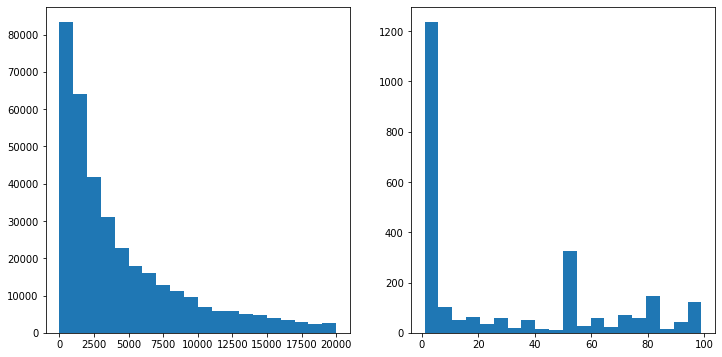

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(12)
_ = ax1.hist(df['Price'], bins=20)
_ = ax2.hist(df[(df['Price'] > 0) & (df['Price'] < 100)]['Price'], bins=20)

In [6]:
df[df['Price'] == 0].shape[0]

10772

Удалим записи цена которых ниже  10 евро.

In [7]:
df = df[df['Price'] >= 10]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342341 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          342341 non-null object
Price                342341 non-null int64
VehicleType          309092 non-null object
RegistrationYear     342341 non-null int64
Gearbox              325391 non-null object
Power                342341 non-null int64
Model                325095 non-null object
Kilometer            342341 non-null int64
RegistrationMonth    342341 non-null int64
FuelType             313357 non-null object
Brand                342341 non-null object
NotRepaired          277152 non-null object
DateCreated          342341 non-null object
NumberOfPictures     342341 non-null int64
PostalCode           342341 non-null int64
LastSeen             342341 non-null object
dtypes: int64(7), object(9)
memory usage: 44.4+ MB


<hr>

Посмотрим на распределение года регистрации

(array([4.50000e+01, 0.00000e+00, 3.00000e+00, 1.20000e+01, 2.30000e+01,
        1.40000e+01, 1.50000e+01, 4.70000e+01, 1.11000e+02, 3.19000e+02,
        5.06000e+02, 1.10800e+03, 1.33100e+03, 2.48400e+03, 7.77300e+03,
        4.37860e+04, 1.00180e+05, 1.12111e+05, 4.60940e+04, 2.62480e+04]),
 array([1910.  , 1915.45, 1920.9 , 1926.35, 1931.8 , 1937.25, 1942.7 ,
        1948.15, 1953.6 , 1959.05, 1964.5 , 1969.95, 1975.4 , 1980.85,
        1986.3 , 1991.75, 1997.2 , 2002.65, 2008.1 , 2013.55, 2019.  ]),
 <a list of 20 Patch objects>)

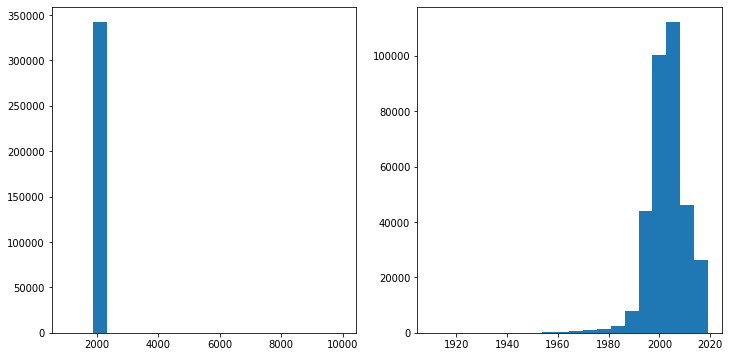

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax1.hist(df['RegistrationYear'], bins=20)
ax2.hist(df[(df['RegistrationYear'] > 1900) & (df['RegistrationYear'] < 2020)]['RegistrationYear'], bins=20)


Есть выбросы слева и справа от которы стоит избавиться. Оставим записи c 1900 по 2020 года

In [9]:
df = df[(df['RegistrationYear'] > 1900) & (df['RegistrationYear'] < 2020)]
df['RegistrationYear'].describe()

count    342210.000000
mean       2003.193329
std           7.338434
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

<hr>

Посмотрим на мощность

(array([   72.,   127.,    63.,    56.,    92.,    81.,   321.,    78.,
          251.,   506.,   983.,  3029.,  4882.,  8086., 19604.,  3011.,
         5539.,  6565., 24609.,  5212.,  3739.,  5507., 12902.,  3515.,
         2124., 21635., 12101., 10052.,  5083., 13172.,  9258.,  7511.,
         7755.,  1962.,  6988., 18726.,  2947., 14479.,  1124.,  1042.,
         8430.,  1273., 10147.,  1845.,  5600.,   842.,  2242.,  1501.,
         4239.,  1264.]),
 array([  1.  ,   4.96,   8.92,  12.88,  16.84,  20.8 ,  24.76,  28.72,
         32.68,  36.64,  40.6 ,  44.56,  48.52,  52.48,  56.44,  60.4 ,
         64.36,  68.32,  72.28,  76.24,  80.2 ,  84.16,  88.12,  92.08,
         96.04, 100.  , 103.96, 107.92, 111.88, 115.84, 119.8 , 123.76,
        127.72, 131.68, 135.64, 139.6 , 143.56, 147.52, 151.48, 155.44,
        159.4 , 163.36, 167.32, 171.28, 175.24, 179.2 , 183.16, 187.12,
        191.08, 195.04, 199.  ]),
 <a list of 50 Patch objects>)

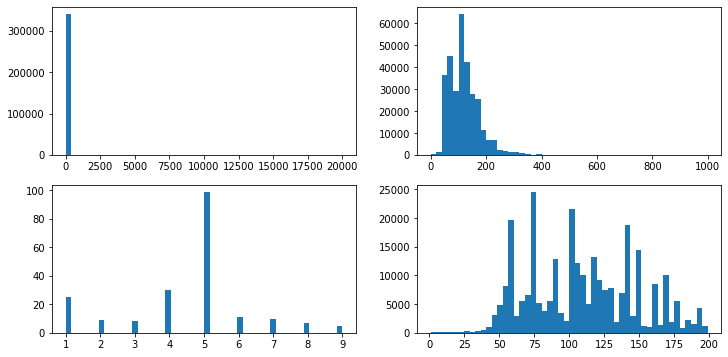

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax1.hist(df['Power'], bins=50)
ax2.hist(df[(df['Power'] > 0) & (df['Power'] < 1000)]['Power'], bins=50)
ax3.hist(df[(df['Power'] > 0) & (df['Power'] < 10)]['Power'], bins=50)
ax4.hist(df[(df['Power'] > 0) & (df['Power'] < 200)]['Power'], bins=50)

Оставим значения мощности между 50 и 400 л.с.

In [11]:
df = df[(df['Power'] >= 50) & (df['Power'] <= 400)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300105 entries, 1 to 354368
Data columns (total 16 columns):
DateCrawled          300105 non-null object
Price                300105 non-null int64
VehicleType          279572 non-null object
RegistrationYear     300105 non-null int64
Gearbox              294515 non-null object
Power                300105 non-null int64
Model                288374 non-null object
Kilometer            300105 non-null int64
RegistrationMonth    300105 non-null int64
FuelType             281258 non-null object
Brand                300105 non-null object
NotRepaired          254860 non-null object
DateCreated          300105 non-null object
NumberOfPictures     300105 non-null int64
PostalCode           300105 non-null int64
LastSeen             300105 non-null object
dtypes: int64(7), object(9)
memory usage: 38.9+ MB


<hr>

Рассмотрим регистрацию месяца?

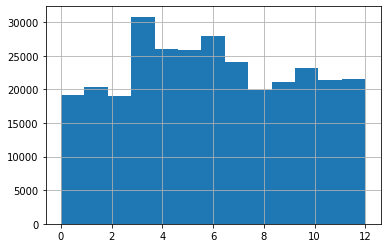

In [12]:
df['RegistrationMonth'].hist(bins=13)

Удаляем "нулевые" месяцы 

In [13]:
df = df[df['RegistrationMonth'] != 0]
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,281014.000000,281014.000000,281014.000000,281014.000000,281014.000000,281014.0,281014.000000
mean,5031.503060,2003.534155,122.014113,128142.637022,6.382803,0.0,51390.834385
std,4629.459838,6.574219,52.000478,36599.983442,3.347042,0.0,25738.449992
min,10.000000,1910.000000,50.000000,5000.000000,1.000000,0.0,1067.000000
25%,1499.000000,1999.000000,80.000000,125000.000000,4.000000,0.0,31134.000000
50%,3400.000000,2004.000000,115.000000,150000.000000,6.000000,0.0,50667.000000
75%,7250.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72172.000000
max,20000.000000,2019.000000,400.000000,150000.000000,12.000000,0.0,99998.000000


<hr>

Удалим незначащие признаки

In [14]:
df = df.drop(axis=1, columns=['DateCrawled', 'LastSeen', 'NumberOfPictures'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281014 entries, 1 to 354368
Data columns (total 13 columns):
Price                281014 non-null int64
VehicleType          265706 non-null object
RegistrationYear     281014 non-null int64
Gearbox              277161 non-null object
Power                281014 non-null int64
Model                271621 non-null object
Kilometer            281014 non-null int64
RegistrationMonth    281014 non-null int64
FuelType             266991 non-null object
Brand                281014 non-null object
NotRepaired          245223 non-null object
DateCreated          281014 non-null object
PostalCode           281014 non-null int64
dtypes: int64(6), object(7)
memory usage: 30.0+ MB


<hr>

Добавим новые признаки **DateRegister**, **DateDiff**.

In [15]:
df['DateRegister'] = df['RegistrationMonth'].astype('str')+'.'+df['RegistrationYear'].astype('str')
# Преобразуем признаки в формат даты
df['DateRegister'] = pd.to_datetime(df['DateRegister'], format='%m.%Y')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S') 
df['DateDiff'] = df['DateCreated'] - df['DateRegister']
df['DateDiffMonth'] = df['DateDiff']/np.timedelta64(1, 'M')
df['DateDiffMonth'] = df['DateDiffMonth'].astype('int')
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,DateRegister,DateDiff,DateDiffMonth
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2011-05-01,1789 days,58
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2004-08-01,4243 days,139
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2001-06-01,5403 days,177
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2008-07-01,2830 days,92
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,1995-10-01,7491 days,246


<hr>

Удаляем пропуски

In [16]:
df.dropna(inplace=True)

In [17]:
df['PostalCode'] = df['PostalCode'].astype('category')
df['RegistrationMonth'] = df['RegistrationMonth'].astype('category')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224060 entries, 3 to 354367
Data columns (total 16 columns):
Price                224060 non-null int64
VehicleType          224060 non-null object
RegistrationYear     224060 non-null int64
Gearbox              224060 non-null object
Power                224060 non-null int64
Model                224060 non-null object
Kilometer            224060 non-null int64
RegistrationMonth    224060 non-null category
FuelType             224060 non-null object
Brand                224060 non-null object
NotRepaired          224060 non-null object
DateCreated          224060 non-null datetime64[ns]
PostalCode           224060 non-null category
DateRegister         224060 non-null datetime64[ns]
DateDiff             224060 non-null timedelta64[ns]
DateDiffMonth        224060 non-null int64
dtypes: category(2), datetime64[ns](2), int64(5), object(6), timedelta64[ns](1)
memory usage: 26.7+ MB


<hr>
Взглянем на корреляцию данных

In [19]:
df.corr()['Price']

Price               1.000000
RegistrationYear    0.577879
Power               0.502033
Kilometer          -0.414941
DateDiffMonth      -0.577778
Name: Price, dtype: float64


Очевидно есть прямая зависимость цены с мощностью и годом регистрации и обратная зависимость с пробегом временем прощедшим с даты регистрации до подачи завявки

# 2. Обучение моделей

<hr>

Функция для оценки качества моделей

In [20]:
def rmse(y_actual, y_predicted):
    return sqrt(mse(y_actual, y_predicted))

<hr>

Готовим данные для обучения моделей

In [21]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop(columns=['Price'], axis=1), df['Price'], test_size=0.2, random_state=42)

cat_features = ['VehicleType', 'Gearbox', 'Model', 
                'FuelType', 'Brand', 'NotRepaired', 
                'RegistrationMonth', 'PostalCode']
num_train_rows = features_train.shape[0]
num_test_rows = features_valid.shape[0]

print('Количество строк для обучения', num_train_rows)
print('Количество строк для предсказания', num_test_rows)

Количество строк для обучения 179248
Количество строк для предсказания 44812


Создадим таблицу для сравнения моделей

In [22]:
compare_cols = {
    'Модель':[],
    'Время обучения':[],
    'Скорость обучения':[],
    'Время предсказания':[],
    'Скорость предсказания':[],
    'RMSE':[],
}
df_compare = pd.DataFrame(compare_cols)

<hr>

КатБуст

In [23]:
%%time
model = CatBoostRegressor(
    loss_function="RMSE", 
    iterations=500, 
    depth=5, 
    l2_leaf_reg=10,
    learning_rate=0.65, 
    random_seed=42,
    bagging_temperature=.5
)

model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 3043.7517995	total: 684ms	remaining: 5m 41s
10:	learn: 1884.5729459	total: 7.06s	remaining: 5m 13s
20:	learn: 1767.4880642	total: 13.5s	remaining: 5m 9s
30:	learn: 1715.4692792	total: 19.3s	remaining: 4m 52s
40:	learn: 1683.8782672	total: 25.4s	remaining: 4m 44s
50:	learn: 1659.4636324	total: 31s	remaining: 4m 32s
60:	learn: 1641.7659271	total: 37s	remaining: 4m 26s
70:	learn: 1627.7598383	total: 43.1s	remaining: 4m 20s
80:	learn: 1615.2255424	total: 49.5s	remaining: 4m 16s
90:	learn: 1604.4128386	total: 55.7s	remaining: 4m 10s
100:	learn: 1595.2622677	total: 1m 1s	remaining: 4m 4s
110:	learn: 1586.2133694	total: 1m 7s	remaining: 3m 57s
120:	learn: 1580.6851075	total: 1m 13s	remaining: 3m 51s
130:	learn: 1574.6257233	total: 1m 20s	remaining: 3m 45s
140:	learn: 1569.0326227	total: 1m 26s	remaining: 3m 39s
150:	learn: 1562.8280525	total: 1m 31s	remaining: 3m 32s
160:	learn: 1558.0358056	total: 1m 38s	remaining: 3m 27s
170:	learn: 1554.6477439	total: 1m 44s	remaining: 3m 20s
180

In [24]:
%%time
predict = model.predict(features_valid)
print(rmse(target_valid, predict))

1558.7714293503036
CPU times: user 904 ms, sys: 32 ms, total: 936 ms
Wall time: 932 ms


In [25]:
df_compare = df_compare.append({
    'Модель':'CatBoost',
    'Время обучения':'4min 55s',
    'Скорость обучения':num_train_rows/(4*60 + 55),
    'Время предсказания':'795 ms',
    'Скорость предсказания':num_test_rows/(0.795),
    'RMSE':'1558'
}, ignore_index=True)

<hr>

Кодирование

In [26]:
cat_features.remove('PostalCode')
df_enc = pd.get_dummies(
    df.drop(axis=1, columns=['PostalCode', 'DateCreated', 'DateRegister', 'DateDiff']), 
    columns=cat_features, 
    drop_first=True
)
features_train, features_valid, target_train, target_valid = train_test_split(
    df_enc.drop(columns=['Price'], axis=1), 
    df_enc['Price'], 
    test_size=0.2, 
    random_state=42
)

num_train_rows = features_train.shape[0]
num_test_rows = features_valid.shape[0]

print('Количество строк для обучения', num_train_rows)
print('Количество строк для предсказания', num_test_rows)

Количество строк для обучения 179248
Количество строк для предсказания 44812


<hr>

XGBoost

In [27]:
%%time

xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    colsample_bytree = 0.7, 
    learning_rate = 0.7,
    max_depth = 10, 
    alpha = 10, 
    n_estimators = 80,
    subsample = 0.5
)
xg_reg.fit(features_train,target_train)



/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CPU times: user 5min 41s, sys: 0 ns, total: 5min 41s
Wall time: 5min 50s


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.7, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=80,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=1)

In [28]:
%%time
predict = xg_reg.predict(features_valid)
print(rmse(target_valid, predict))

1706.4110629938998
CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 809 ms


In [29]:
df_compare = df_compare.append({
    'Модель':'XGB',
    'Время обучения':'5min 13s',
    'Скорость обучения':num_train_rows/(5*60 + 13),
    'Время предсказания':'718 ms',
    'Скорость предсказания':num_test_rows/(0.718),
    'RMSE':'1706'
}, ignore_index=True)

<hr>

LightGBM

In [30]:
%%time
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 41,
    'learning_rate': 0.65,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 10
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5
)


[1]	valid_0's l2: 7.45377e+06	valid_0's l1: 2072.89
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 4.84004e+06	valid_0's l1: 1572.45
[3]	valid_0's l2: 3.99316e+06	valid_0's l1: 1361.84
[4]	valid_0's l2: 3.60213e+06	valid_0's l1: 1275.81
[5]	valid_0's l2: 3.41195e+06	valid_0's l1: 1232.15
[6]	valid_0's l2: 3.30421e+06	valid_0's l1: 1205.43
[7]	valid_0's l2: 3.20294e+06	valid_0's l1: 1185.36
[8]	valid_0's l2: 3.1525e+06	valid_0's l1: 1175.94
[9]	valid_0's l2: 3.08452e+06	valid_0's l1: 1158.57
[10]	valid_0's l2: 3.03671e+06	valid_0's l1: 1147.27
[11]	valid_0's l2: 3.00029e+06	valid_0's l1: 1140.76
[12]	valid_0's l2: 2.95547e+06	valid_0's l1: 1132.22
[13]	valid_0's l2: 2.93515e+06	valid_0's l1: 1128.1
[14]	valid_0's l2: 2.91561e+06	valid_0's l1: 1124.2
[15]	valid_0's l2: 2.89699e+06	valid_0's l1: 1119.01
[16]	valid_0's l2: 2.86079e+06	valid_0's l1: 1110.5
[17]	valid_0's l2: 2.83495e+06	valid_0's l1: 1105.47
[18]	valid_0's l2: 2.81475e+06	valid_0's l1: 1100.16

In [31]:
%%time

y_pred = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
print(rmse(target_valid, y_pred))

1672.4636593247094
CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 319 ms


In [32]:
df_compare = df_compare.append({
    'Модель':'LightGBM',
    'Время обучения':'2.75 s',
    'Скорость обучения':num_train_rows/(2.75),
    'Время предсказания':'311 ms',
    'Скорость предсказания':num_test_rows/(0.311),
    'RMSE':'1672'
}, ignore_index=True)

# 3. Анализ моделей

Для проверки на адекватность:Константая модель - всегда дает среднее значение

In [33]:
class Const_model:
    def fit(self, y, mode='mean'):
        if mode == 'mean':
            self.y = y.mean()
        if mode == 'median':
            self.y = y.median()
        
    def predict(self, x):
        return [self.y for _ in range(len(x))]

In [34]:
%%time
const_m = Const_model()
const_m.fit(target_train, mode='mean')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 833 µs


In [35]:
%%time
pred = const_m.predict(target_valid)
print(rmse(target_valid, pred))

4733.201731464316
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.1 ms


In [36]:
df_compare = df_compare.append({
    'Модель':'Test',
    'Время обучения':'822 µs',
    'Скорость обучения':num_train_rows/(0.000822),
    'Время предсказания':'9.7 ms',
    'Скорость предсказания':num_test_rows/(0.0097),
    'RMSE':'4733'
}, ignore_index=True)

# Вывод

In [38]:
df_compare

,Модель,Время обучения,Скорость обучения,Время предсказания,Скорость предсказания,RMSE
0,CatBoost,4min 55s,6.076203e+02,795 ms,5.636730e+04,1558
1,XGB,5min 13s,5.726773e+02,718 ms,6.241226e+04,1706
2,LightGBM,2.75 s,6.518109e+04,311 ms,1.440900e+05,1672
3,Test,822 µs,2.180633e+08,9.7 ms,4.619794e+06,4733


Все модели лучше константой модели, т.е. адекватны. <br>
Самая высокая скорость обучения и предсказания (количество записей в секунду) у моедли LightGBM. Но лучше качество метрики у модели CatBoost. <br>
- Если надо выбрать саму быструю по предсказаниям модель, то LightGBM
- Если саму точную, то CatBoost